Imports and functions from task 1 & 2 to be used again in this task. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares as nls

def Read_file(filename):
    data = []
    filename = filename + ".txt"
    file = open(filename, "r")
    for coor in file:
        data.append(coor.split())
    data = np.array(data, dtype='float')
    x = data[:,0]
    y = data[:,1]
    return x, y

def Least_squares(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    plt.figure(figsize=(16,14))
    plt.plot(x, y, 'o', label="Original Data", markersize=2)
    plt.plot(x, m*x + c, "r", label="Fitted Line")
    plt.legend()
    plt.show()

loading the data

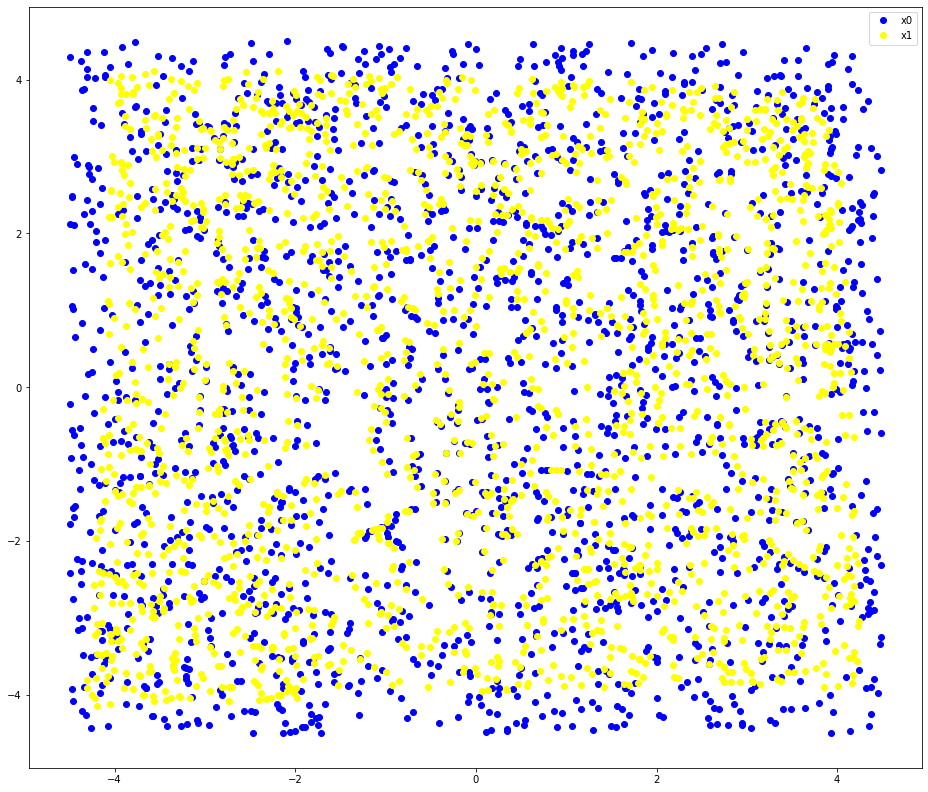

In [2]:
x0 = np.array(Read_file("nonlinear_vectorfield_data_x0"))
x1 = np.array(Read_file("nonlinear_vectorfield_data_x1"))
plt.figure(figsize=(16,14))
plt.plot(x0[0,:], x0[1,:], 'o', label="x0", color="blue")
plt.plot(x1[0,:], x1[1,:], 'o', label="x1", color="yellow")
plt.legend()
plt.show()

## 1) Estimate the vector field with a linear operator. 

In [3]:
dt = 0.1
dphidt = (x1 - x0)/dt

coef = np.linalg.lstsq(dphidt, x0, rcond=None)
A = coef[0]
print('linear operator: A = ')
print(A)

linear operator: A = 
[[ 0.00051103  0.00028759 -0.00028723 ... -0.00022994 -0.00055454
   0.0003238 ]
 [-0.0013164  -0.00292008 -0.00118301 ...  0.00268248  0.00015835
  -0.00019785]
 [ 0.00075513  0.00134769  0.00038976 ... -0.00122478 -0.00028163
   0.00020907]
 ...
 [ 0.00056538  0.00347755  0.00246998 ... -0.00328461  0.00122788
  -0.00056418]
 [ 0.00139257  0.00198204  0.00027468 ... -0.00177595 -0.00081271
   0.0005325 ]
 [ 0.00010193 -0.00091708 -0.00091712 ...  0.00088875 -0.00067855
   0.00034909]]


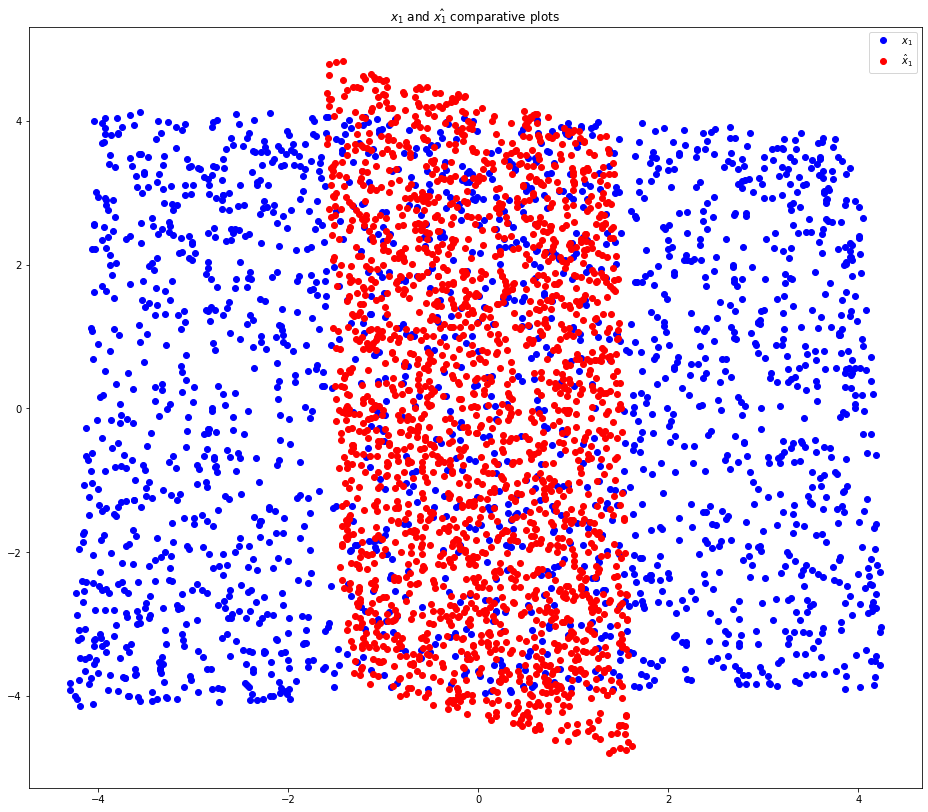

In [4]:
#estimating x1
x1_hat = x0.dot(A)

plt.figure(figsize=(16,14))
plt.title(r'$x_1$ and $\hat{x_1}$ comparative plots')
plt.plot(x1[0,:], x1[1,:], 'o', label=r"$x_1$", color="blue")
plt.plot(x1_hat[0,:], x1_hat[1,:], 'o', label=r"$\hat{x}_1$", color="red")
plt.legend()
plt.show()

In [5]:
#computation of the mean square error

def MSE(y,y_pred): 
    mse = 0
    for k in range(y.shape[0]) : 
        error = np.linalg.norm(y-y_pred)**(2)
        mse += error
    return mse


mse = MSE(x1,x1_hat)
print('The mean square error is : ' + str(mse))

The mean square error is : 147207.6934666712


## 2) Radial basis function approximation

In [6]:
def phi(C,x) : 
    ''' 
    The radial function, as the one see in class id est : 
    exp(-||xl - x||**(2)/eps**(2))
    L is the number of coordinates for the vector C, we then choose the x_l, centers of basis functions distributed between
    the maximum and the minimum of the values of x. 
    
    '''
    eps = 0.1
    L = len(C)
        
    x_max = np.amax(x)
    x_min = np.amin(x)
        
        
    x_ls =  np.linspace(x_min,x_max,num = L)
        
        
        
    f_hat = np.zeros(x.shape)
    for l in range(L) : 
        phi_l = np.exp(-np.power(x_ls[l]*np.ones(x.shape)-x,2)/np.linalg.norm(eps)**(2))
        f_hat += phi_l*C[l]
           
        
    return f_hat


def fun(C,x,y) :
    '''The function we want to minimise with the least squares minimisation'''
    return phi(C,x) - y
    
    

    
    
    
def radial_function_solving(x0,x1,dt,L) : 
    '''Given the data points x0 and x1, the time difference and L, the 
    number of variables in the radial function we want, we compute the prediction of 
    the next coordinates'''
    
    dphidt = (x1 - x0)/dt # the speed
    
    x_hat = np.zeros(x0.shape)
    Cs = []
    for i in range(x0.shape[0]) :
        C0 = np.ones(L) #initial guess of c-coefficients
        res_lsq = nls(fun, C0, args=(x0[i,:], dphidt[i,:]))
        C = res_lsq.x

        f_hat = phi(C,x0[i,:])
        x_hat[i,:] = f_hat*dt + x0[i,:]
        Cs.append(C)
    
    return x_hat,Cs


In [7]:
dt = 0.1
L = 500
x_hat,Cs = radial_function_solving(x0,x1,dt,L)
mse = MSE(x1,x_hat)
print('The mean square error is : ' + str(mse))

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16,14))
plt.title(r'$x_1$ and $\hat{x_1}$ comparative plots')
plt.plot(x1[0,:], x1[1,:], 'o', label=r"$x_1$", color="blue")
plt.plot(x_hat[0,:], x_hat[1,:], 'o', label=r"$\hat{x}_1$", color="red")
plt.legend()
plt.show()

## 3) Approximated vector field

a) ploting the approximated vector field

In [ ]:
v = (x_hat - x0)/dt
dx = v[:,0]
dy = v[:,1]

plt.figure(figsize=(16,14))
plt.quiver(x0[:,0], x0[:,1], dx, dy)
plt.show()

b) solving the system for a longer time

In [ ]:
def long_time_solving(x0,x1,L,dt=0.1,num_iter = 20) : 
    states = [x0]
    for i in range(num_iter) : 
        x_hat = radial_function_solving(x0,x1,dt,L)
        states.append(x_hat)
        
        v = (x_hat - x0)/dt
        x0 = x_hat
        x1 = v*dt + x0
        
    return states
        

In [ ]:
states = long_time_solving(x0,x1,L,dt=0.1,num_iter = 20)
